# Capstone Project - Restaurants in Kraków

#### Importing Libraries

In [1]:
import pandas as pd
import folium
from folium import plugins
import requests

#### Getting Data

In [2]:
CLIENT_ID = 'x'
CLIENT_SECRET = 'x'

request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": '20180605',
    "section": "food",
    "near": "Krakow",
    "radius": 2000,
    "limit": 100}

In [3]:
data = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters)

#### Examine Data

We keep the data in a dict

In [4]:
d = data.json()["response"]
d.keys()

dict_keys(['suggestedFilters', 'geocode', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'query', 'totalResults', 'suggestedBounds', 'groups'])

In [5]:
d

{'suggestedFilters': {'header': 'Tap to show:',
  'filters': [{'name': 'Open now', 'key': 'openNow'}]},
 'geocode': {'what': '',
  'where': 'krakow',
  'center': {'lat': 50.06143, 'lng': 19.93658},
  'displayString': 'Krakow, Poland',
  'cc': 'PL',
  'geometry': {'bounds': {'ne': {'lat': 50.125746929273035,
     'lng': 20.217017998898445},
    'sw': {'lat': 49.96750603553661, 'lng': 19.793890515115354}}},
  'slug': 'krakow-poland',
  'longId': '72057594041022738'},
 'headerLocation': 'Krakow',
 'headerFullLocation': 'Krakow',
 'headerLocationGranularity': 'city',
 'query': 'food',
 'totalResults': 214,
 'suggestedBounds': {'ne': {'lat': 50.070126828593665,
   'lng': 19.954546917244976},
  'sw': {'lat': 50.04836732046805, 'lng': 19.917388733880976}},
 'groups': [{'type': 'Recommended Places',
   'name': 'recommended',
   'items': [{'reasons': {'count': 0,
      'items': [{'summary': 'This spot is popular',
        'type': 'general',
        'reasonName': 'globalInteractionReason'}]},
  

We deep into the dict to understand the data

In [6]:
d["headerLocationGranularity"], d["headerLocation"], d["headerFullLocation"]

('city', 'Krakow', 'Krakow')

In [7]:
d["suggestedBounds"], d["totalResults"]


({'ne': {'lat': 50.070126828593665, 'lng': 19.954546917244976},
  'sw': {'lat': 50.04836732046805, 'lng': 19.917388733880976}},
 214)

Let's take the data we want

In [8]:
items = d["groups"][0]["items"]
print("number of items: %i" % len(items))
items[0] # Example of the data of one restaurant

number of items: 100


{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '597cc55b6dcf041c42573b04',
  'name': 'Pizzatopia',
  'location': {'address': 'Szewska 22',
   'lat': 50.062943238240265,
   'lng': 19.933833687142826,
   'labeledLatLngs': [{'label': 'display',
     'lat': 50.062943238240265,
     'lng': 19.933833687142826}],
   'postalCode': '31-009',
   'cc': 'PL',
   'city': 'Kraków',
   'state': 'Lesser Poland',
   'country': 'Polska',
   'formattedAddress': ['Szewska 22', '31-009 Kraków', 'Polska']},
  'categories': [{'id': '4bf58dd8d48988d1ca941735',
    'name': 'Pizza Place',
    'pluralName': 'Pizza Places',
    'shortName': 'Pizza',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-3-597cc55b6dcf041c42573b04-0'}

We transform the data, and we get a dataframe with the required data

In [9]:
df_raw = []
for item in items:
    venue = item["venue"]
    categories, uid, name, location = venue["categories"], venue["id"], venue["name"], venue["location"]
    assert len(categories) == 1
    shortname = categories[0]["shortName"]
    if not "address" in location:
        continue
    address = location["address"]
    if not "postalCode" in location:
        continue
    postalcode = location["postalCode"]
    lat = location["lat"]
    lng = location["lng"]
    datarow = (uid, name, shortname, address, postalcode, lat, lng)
    df_raw.append(datarow)
df = pd.DataFrame(df_raw, columns=["uid", "name", "food", "address", "postalcode", "lat", "lng"])
print("found %i restaurants" % len(df))
df.head(10)

found 63 restaurants


,uid,name,food,address,postalcode,lat,lng
0,597cc55b6dcf041c42573b04,Pizzatopia,Pizza,Szewska 22,31-009,50.062943,19.933834
1,53e678c5498e35f10c8bcbfa,Bianca Pasta & Wine,Italian,Plac Mariacki 2,31-042,50.061899,19.939741
2,56377311498ea3a0befc336c,Bonerowska Gourmet Steak & Fish,Steakhouse,Rynek Główny 42,31-013,50.062246,19.937987
3,4b813ff5f964a520259c30e3,Café Camelot,Café,Świętego Tomasza 17,31-022,50.063098,19.939010
4,4e6f50cb483bd41a3db4dfa4,MoaBurger,Burgers,Mikołajska 3,31-027,50.061306,19.941310
5,592005654940bc3f72327973,La Petite France,French,Szpitalna 20,31-024,50.062825,19.941311
6,4facdb7fe5e83b277dae66de,Charlotte - Chleb i Wino,Café,Plac Szczepański 2,31-011,50.063455,19.935069
7,4c00dc18ceabb7138aef8752,Bunkier Café,Café,Plac Szczepański 3a,31-011,50.063577,19.934080
8,4be1a1a885670f474eae2bd7,Morskie Oko,Polish,Plac Szczepański 8,31-011,50.063814,19.935762
9,53a1380f498e903f74523f65,Massolit Bakery & Cafe,Bakery,Smoleńsk 17,31-108,50.058975,19.930351


AxesSubplot(0.125,0.125;0.775x0.755)


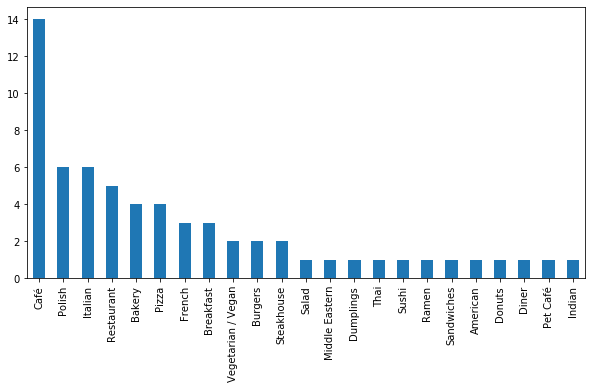

In [10]:
print(df['food'].value_counts().plot(kind='bar', figsize=(10,5)))

We save the lat and lng of the center of Krakow. It is useful for creating the map

In [11]:
krakow_center = d["geocode"]["center"]
krakow_center

{'lat': 50.06143, 'lng': 19.93658}

We create the map of Kraków with the restaurants

In [12]:
map_krakow = folium.Map(location=[krakow_center["lat"], krakow_center["lng"]], zoom_start=14)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html=True)
        folium.CircleMarker(
            [row["lat"], row["lng"]],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_krakow)

add_markers(df)
hm_data = df[['lat','lng']].values.tolist()
map_krakow.add_child(plugins.HeatMap(hm_data))

map_krakow

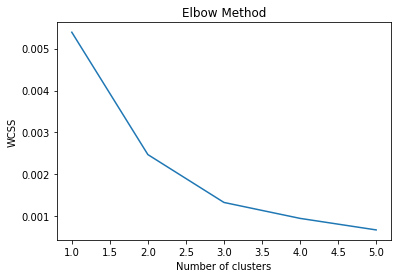

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df[['lat', 'lng']]

wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

In [15]:
df['cluster'] = pred_y

In [16]:
map_krakow = folium.Map(location=[krakow_center["lat"], krakow_center["lng"]], zoom_start=14)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html=True)
        if row['cluster']==0:
            folium.CircleMarker(
                [row["lat"], row["lng"]],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.7,
                parse_html=False).add_to(map_krakow)
        elif row['cluster']==1:
            folium.CircleMarker(
                [row["lat"], row["lng"]],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
                parse_html=False).add_to(map_krakow)
        else:
            folium.CircleMarker(
                [row["lat"], row["lng"]],
                radius=5,
                popup=label,
                color='green',
                fill=True,
                fill_color='green',
                fill_opacity=0.7,
                parse_html=False).add_to(map_krakow)

add_markers(df)

map_krakow

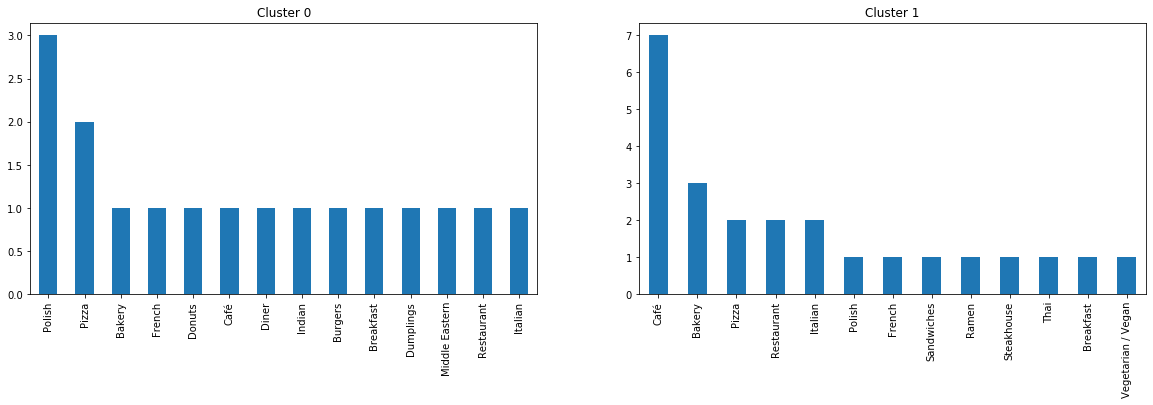

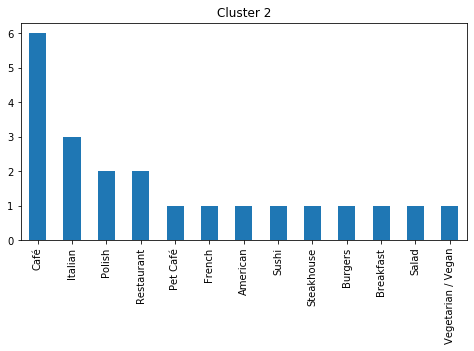

In [22]:
fig1, (ax1, ax2) = plt.subplots(1,2)
fig2, ax3 = plt.subplots(1,1)


df_0 = df[df['cluster']==0]
df_1 = df[df['cluster']==1]
df_2 = df[df['cluster']==2]

df_0['food'].value_counts().plot(kind='bar', figsize=(20,5), title='Cluster 0', ax = ax1)
df_1['food'].value_counts().plot(kind='bar', figsize=(20,5), title='Cluster 1', ax = ax2)
df_2['food'].value_counts().plot(kind='bar', figsize=(8,4), title='Cluster 2', ax = ax3)

We want a location close to the center and to the river, good location and there are not many restaurants. This is the cluster 1, the red, therefore a cafe would not be a good option, but anything else could be ok. A cafe would be a really good option for the cluster 0.

In [23]:
# center: {'lat': 50.06143, 'lng': 19.93658}
lat = 50.05524
lng = 19.93358
map_krakow = folium.Map(location=[lat, lng], zoom_start=17)
add_markers(df)
folium.CircleMarker(
    [lat, lng],
    radius=15,
    popup="Our Cafe!",
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_krakow)
map_krakow